In [1]:
# data analysis
import pandas as pd

# visualization
import seaborn as sns
from  matplotlib import pyplot as plt

# sats
from statsmodels.tsa.seasonal import STL

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import r2_score

In [6]:
# Import and clean data

df = pd.read_csv('../../data/processed/dax_close').drop(columns='Unnamed: 0')
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={"close":"DAX","DE05Y, TVC: Close": "DE05Y","DE10Y, TVC: Close":"DE10Y","DE30Y, TVC: Close":"DE30Y"}, inplace=True)

In [7]:
df.drop(columns='Volume').corr()

,DAX,DE05Y,DE10Y,DE30Y
DAX,1.000000,-0.871160,-0.909124,-0.884944
DE05Y,-0.871160,1.000000,0.989926,0.973742
DE10Y,-0.909124,0.989926,1.000000,0.995452
DE30Y,-0.884944,0.973742,0.995452,1.000000


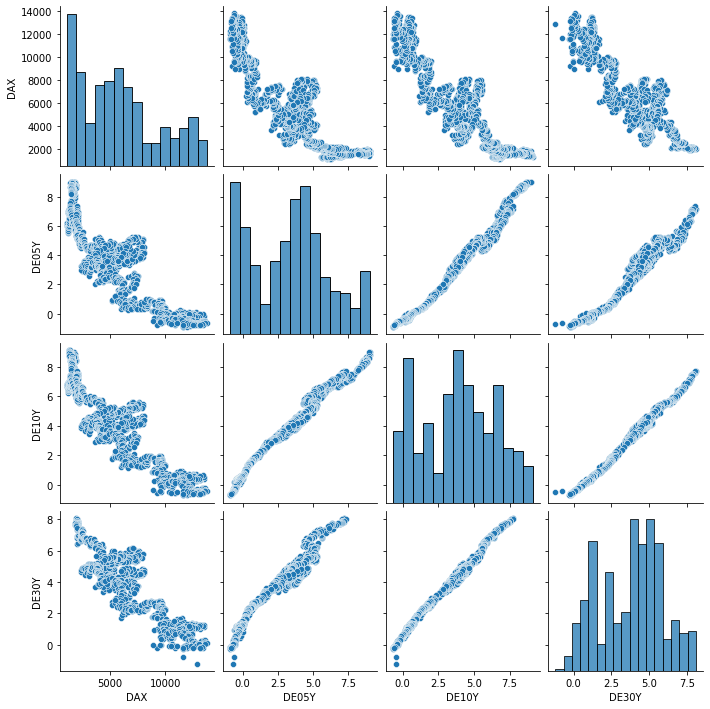

In [8]:
sns.pairplot(df.drop(columns='Volume'))

In [9]:
df.columns

Index(['date', 'DAX', 'DE05Y', 'DE10Y', 'DE30Y', 'Volume'], dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1692 non-null   datetime64[ns]
 1   DAX     1692 non-null   float64       
 2   DE05Y   1670 non-null   float64       
 3   DE10Y   1627 non-null   float64       
 4   DE30Y   1350 non-null   float64       
 5   Volume  0 non-null      float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 79.4 KB


In [41]:
df = df[df['DE10Y'].notna()]
df.set_index(df['date'],inplace=True)

In [42]:
df['date'].asfreq(freq='w')
df.set_index(df['date'],inplace=True)


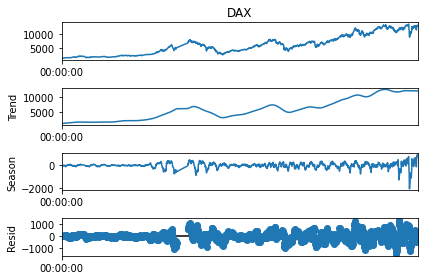

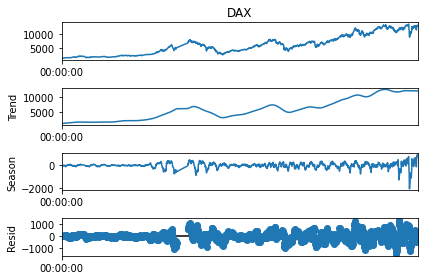

In [43]:
stl = STL(df['DAX'], period =50)
res = stl.fit()
res.plot()

In [44]:
dax_trend = res.trend
dax_seasonal = res.seasonal
dax_resid = res.resid
dax_weights = res.weights

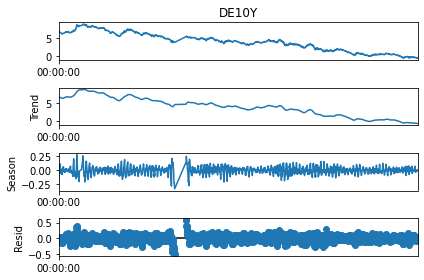

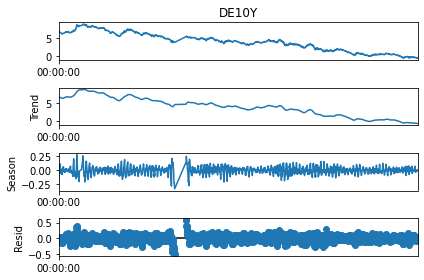

In [63]:
stl = STL(df['DE10Y'], period =15)
res2 = stl.fit()
res2.plot()

In [46]:
de10y_trend = res2.trend
de10y_seasonal = res2.seasonal

de10y_resid = res2.resid
de10y_weights = res2.weights

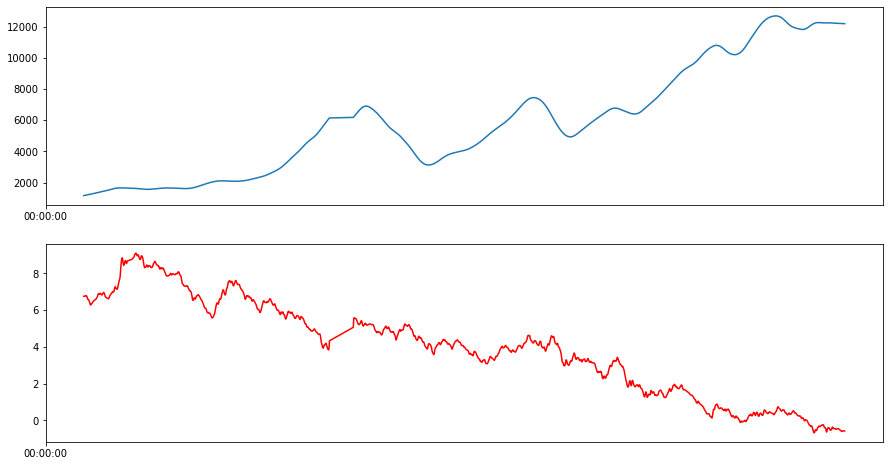

In [47]:
## Trend
fig, ax = plt.subplots(2,figsize=(15,8))
ax[0].plot(dax_trend)
ax[1].plot(de10y_trend, color = 'r');

- The picture above compares the trend  

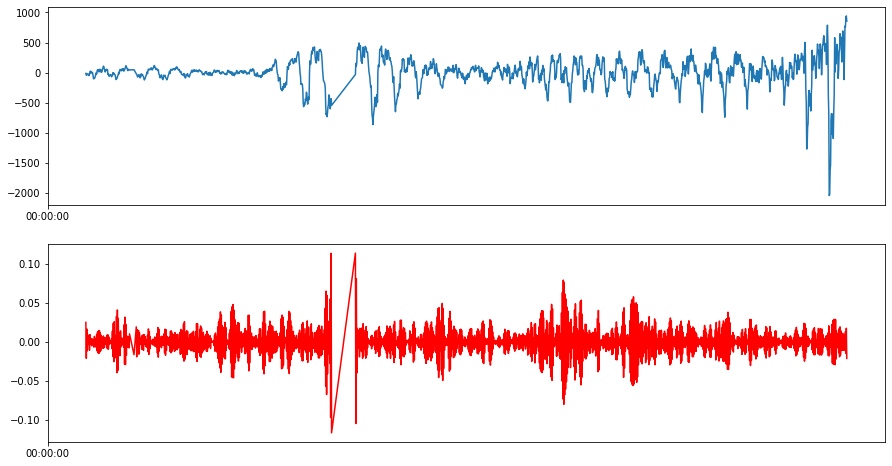

In [48]:
## seasonal
fig, ax = plt.subplots(2,figsize=(15,8))
ax[0].plot(dax_seasonal)
ax[1].plot(de10y_seasonal, color = 'r');

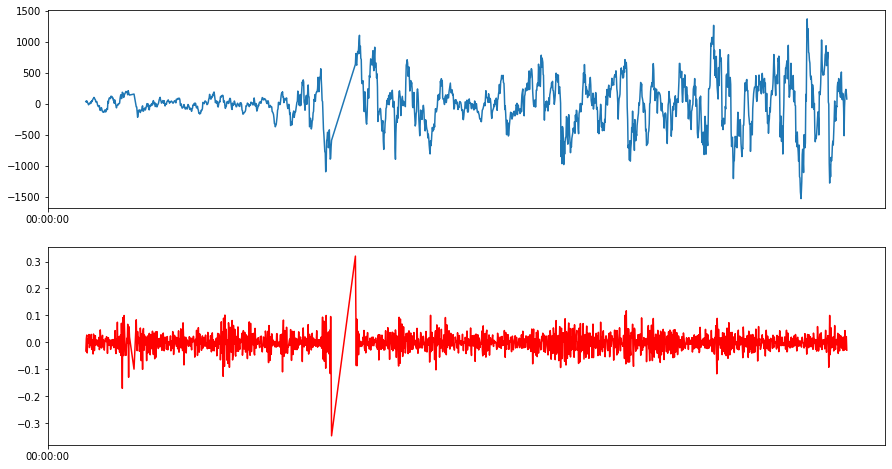

In [49]:
## resid
fig, ax = plt.subplots(2,figsize=(15,8))
ax[0].plot(dax_resid)
ax[1].plot(de10y_resid, color = 'r');

In [50]:
# helper
def fit_poly(X,y,k):
    # Transforms our data to allow for Polynomial regression (Matrix from last class)
    poly = PolynomialFeatures(k)
    X_poly = poly.fit_transform(X.reshape(-1,1))
    # Linear Regression Model
    lr = LinearRegression()
    lr.fit(X_poly,y)
    return lr

### Polinomial Regression k = 2

In [51]:
## importing modules
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.evaluate import bias_variance_decomp


Coeficients:[    0.         -1959.90177308    91.04876295], 
Intercept:11560.912956198074
y = 11560.912956198074x^0+-1959.9017730796622x^1+91.04876294703945x^2


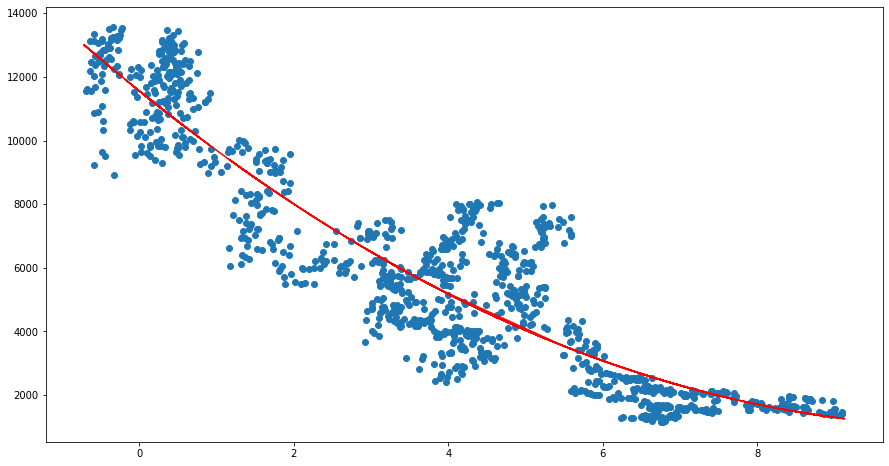

In [52]:
# double splitting
X, y = df[['DE10Y']].values,df['DAX'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

# Calling
lr = fit_poly(X_train,y_train,2)

# Variables regression 
print(f'Coeficients:{lr.coef_}, \nIntercept:{lr.intercept_}')

# The function
b0,b1,b2 = lr.coef_
b0 = lr.intercept_
lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
print(f"y = {b0}x^0+{b1}x^1+{b2}x^2")

# plotting on train 
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_train,y_train)
plt.plot(X, lr_func(X),c="red");

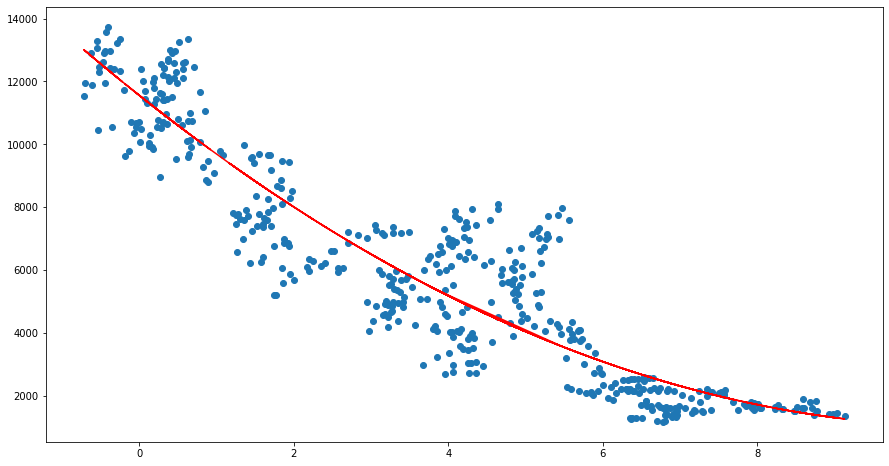

In [53]:
# plotting on test
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_test,y_test)
plt.plot(X, lr_func(X),c="red");

In [54]:
## Metrics
from sklearn.metrics import r2_score
pre_process = PolynomialFeatures(degree=2)
test_y_pred = lr.predict(pre_process.fit_transform(X_test))

r2_test = r2_score(y_true=y_test, y_pred=test_y_pred )
print(f'R2:{r2_test}')

R2:0.855893975827024


## Polinomial Regression 2 Lagged DAX

In [57]:
leading1 = df[['DE10Y']][:-12]
lagged1 = df['DAX'][12:]

Coeficients:[    0.         -1974.37988989    89.43360719], 
Intercept:11754.448498642094
y = 11754.448498642094x^0+-1974.3798898943655x^1+89.43360718817394x^2


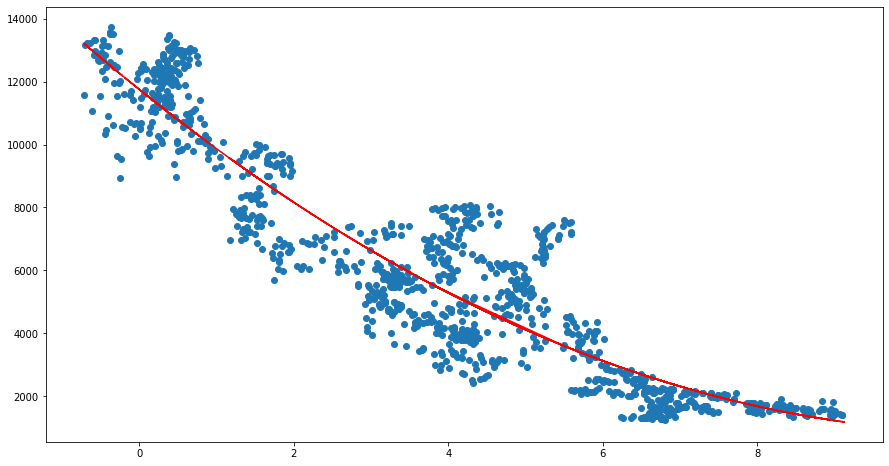

In [58]:
# double splitting
X, y = leading1.values,lagged1.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

# Calling
lr = fit_poly(X_train,y_train,2)

# Variables regression 
print(f'Coeficients:{lr.coef_}, \nIntercept:{lr.intercept_}')

# The function
b0,b1,b2 = lr.coef_
b0 = lr.intercept_
lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
print(f"y = {b0}x^0+{b1}x^1+{b2}x^2")

# plotting on train 
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_train,y_train)
plt.plot(X, lr_func(X),c="red");

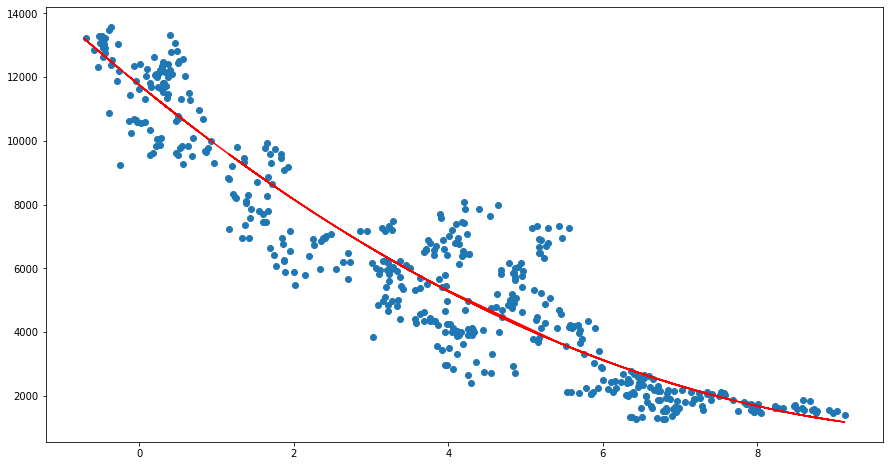

In [59]:
# plotting on test
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(X_test,y_test)
plt.plot(X, lr_func(X),c="red");

In [60]:
## Metrics
from sklearn.metrics import r2_score
pre_process = PolynomialFeatures(degree=2)
test_y_pred = lr.predict(pre_process.fit_transform(X_test))

r2_test = r2_score(y_true=y_test, y_pred=test_y_pred )
print(f'R2:{r2_test}')

R2:0.8832037305944442


### Polinomial Regression  Lagged Function

Coeficients:[    0.         -1974.37988989    89.43360719], 
Intercept:11754.448498642094
y = 11754.448498642094x^0+-1974.3798898943655x^1+89.43360718817394x^2
R2:0.8832037305944442


(0.8832037305944442,
 11754.448498642094,
 array([    0.        , -1974.37988989,    89.43360719]))

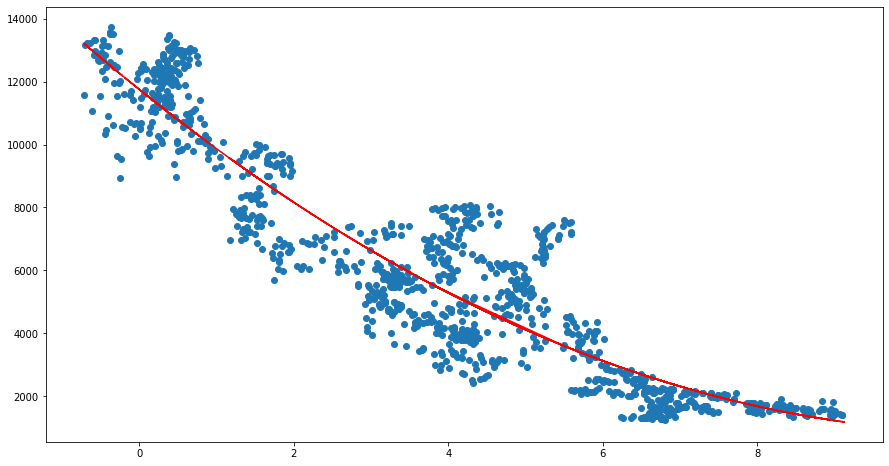

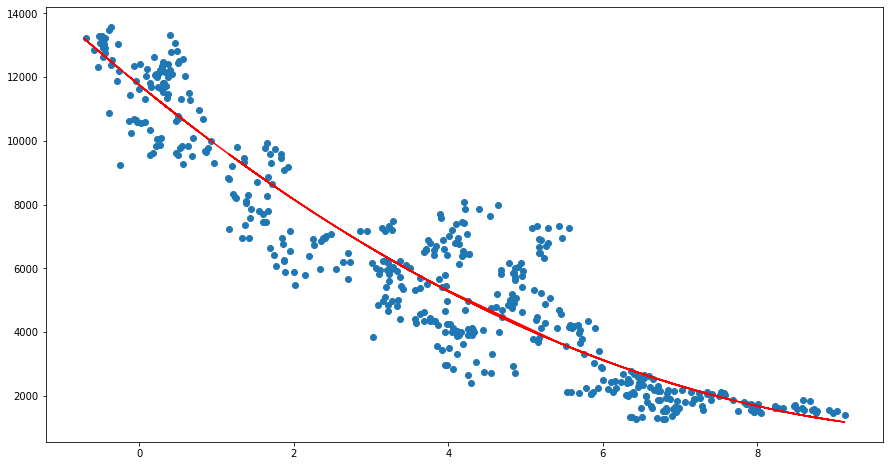

In [61]:
# double splitting
X, y = leading1.values,lagged1.values

def polinomial2_regression (X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=2)

    # Calling
    lr = fit_poly(X_train,y_train,2)

    # Variables regression 
    print(f'Coeficients:{lr.coef_}, \nIntercept:{lr.intercept_}')

    # The function
    b0,b1,b2 = lr.coef_
    b0 = lr.intercept_
    lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
    print(f"y = {b0}x^0+{b1}x^1+{b2}x^2")

    # plotting on train 
    fig, ax = plt.subplots(figsize=(15,8))
    plt.scatter(X_train,y_train)
    plt.plot(X, lr_func(X),c="red");

    # plotting on test
    fig, ax = plt.subplots(figsize=(15,8))
    plt.scatter(X_test,y_test)
    plt.plot(X, lr_func(X),c="red");

    pre_process = PolynomialFeatures(degree=2)
    test_y_pred = lr.predict(pre_process.fit_transform(X_test))

    r2_test = r2_score(y_true=y_test, y_pred=test_y_pred )
    print(f'R2:{r2_test}')
    
    return (r2_test,lr.intercept_,lr.coef_)

polinomial2_regression(leading1.values,lagged1.values)